In [4]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import json
from scipy.signal import welch
import h5py
from tqdm import tqdm
import re

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [5]:
class AeroelasticDataProcessor:
    def __init__(self, base_path="D:/Projects/aeroelasticity/data"):
        self.base_path = Path(base_path)
        
        # Correct lRef values for each shape
        self.correct_lref = {
            'baseline': 1.5,
            'taller': 2.0,
            'shorter': 1.0
        }
        
        # Shape parameters (you can adjust these to match your actual geometry)
        self.shape_params = {
            'baseline': {'D': 3.0, 'H': 1.5},   # lRef = 3.0m
            'taller': {'D': 3.0, 'H': 2.0},     # lRef should be 2.0m
            'shorter': {'D': 3.0, 'H': 1.0}     # lRef should be 1.0m
        }
        
        # Wind speed mapping (will be extracted from files)
        self.wind_speeds = {}
        
        # Kinematic viscosity (m²/s)
        self.nu = 1.0e-5
        
    def scan_available_data(self):
        """Scan directory structure to find all available simulations"""
        available_data = []
        
        for shape_dir in self.base_path.iterdir():
            if shape_dir.is_dir() and any(s in shape_dir.name for s in ['baseline', 'taller', 'shorter']):
                shape_name = shape_dir.name
                
                for angle_dir in shape_dir.iterdir():
                    if angle_dir.is_dir() and angle_dir.name.isdigit():
                        angle = int(angle_dir.name)
                        
                        # Check if forceCoeffs.dat exists
                        force_file = angle_dir / "postProcessing/cylinder/0/forceCoeffs.dat"
                        if force_file.exists():
                            available_data.append({
                                'shape': shape_name,
                                'angle': angle,
                                'path': angle_dir,
                                'force_file': force_file
                            })
        
        return pd.DataFrame(available_data)

In [6]:
class ForceCoeffsReader:
    @staticmethod
    def parse_header(force_file_path):
        """Parse the header of forceCoeffs.dat to extract metadata"""
        metadata = {}
        
        with open(force_file_path, 'r') as f:
            lines = f.readlines()
            
        # Parse header lines (first 9 lines)
        for line in lines[:9]:
            if 'magUInf' in line:
                # Extract velocity magnitude
                match = re.search(r'magUInf\s*:\s*([\d.e+-]+)', line)
                if match:
                    metadata['U_ref'] = float(match.group(1))
                    
            elif 'lRef' in line:
                # Extract reference length
                match = re.search(r'lRef\s*:\s*([\d.e+-]+)', line)
                if match:
                    metadata['lRef_original'] = float(match.group(1))
                    
            elif 'Aref' in line:
                # Extract reference area
                match = re.search(r'Aref\s*:\s*([\d.e+-]+)', line)
                if match:
                    metadata['Aref'] = float(match.group(1))
                    
            elif 'CofR' in line:
                # Extract center of rotation
                match = re.findall(r'([-\d.e+-]+)', line)
                if len(match) >= 3:
                    metadata['CofR'] = [float(match[0]), float(match[1]), float(match[2])]
                    
            elif 'liftDir' in line:
                # Extract lift direction
                match = re.findall(r'([-\d.e+-]+)', line)
                if len(match) >= 3:
                    metadata['liftDir'] = [float(match[0]), float(match[1]), float(match[2])]
                    
            elif 'dragDir' in line:
                # Extract drag direction
                match = re.findall(r'([-\d.e+-]+)', line)
                if len(match) >= 3:
                    metadata['dragDir'] = [float(match[0]), float(match[1]), float(match[2])]
        
        return metadata
    
    @staticmethod
    def read_coefficients(force_file_path):
        """Read force coefficients from forceCoeffs.dat"""
        # Read the data, skipping header
        df = pd.read_csv(force_file_path, skiprows=9, sep='\t', 
                        header=None, names=["t", "Cm", "Cd", "Cl", "Clf", "Clr"])
        
        # Extract metadata
        metadata = ForceCoeffsReader.parse_header(force_file_path)
        
        return df, metadata

In [ ]:
class ForceProcessor:
    def __init__(self, shape_params, metadata, shape_type):
        self.shape_type = shape_type
        self.D = shape_params['D']
        self.H = shape_params['H']
        self.U_ref = metadata['U_ref']
        self.lref_original = metadata['lRef_original']
        self.metadata = metadata
        
    def correct_coefficients(self, df, correct_lref):
        """Correct coefficients if lRef was wrong in the simulation"""
        if self.shape_type in ['shorter', 'taller'] and self.lref_original != correct_lref:
            # Coefficients scale with lRef ratio for 2D cases
            correction_factor = self.lref_original / correct_lref
            
            # Apply correction
            df_corrected = df.copy()
            df_corrected['Cd'] = df['Cd'] * correction_factor
            df_corrected['Cl'] = df['Cl'] * correction_factor
            df_corrected['Cm'] = df['Cm'] * correction_factor  # Moment scales with lRef²/lRef = lRef
            
            print(f"Applied lRef correction for {self.shape_type}: {self.lref_original}m → {correct_lref}m")
            return df_corrected
        else:
            return df
    
    def compute_mean_coefficients(self, df, settling_time=80):
        """Compute time-averaged coefficients after flow settles"""
        mask = df['t'] > settling_time
        
        mean_cd = df.loc[mask, 'Cd'].mean()
        mean_cl = df.loc[mask, 'Cl'].mean()
        mean_cm = df.loc[mask, 'Cm'].mean()
        
        std_cd = df.loc[mask, 'Cd'].std()
        std_cl = df.loc[mask, 'Cl'].std()
        std_cm = df.loc[mask, 'Cm'].std()
        
        return {
            'mean': [mean_cd, mean_cl, mean_cm],
            'std': [std_cd, std_cl, std_cm]
        }
    
    def compute_psd(self, df, settling_time=100):
        """Compute PSD of lift coefficient"""
        mask = df['t'] > settling_time
        cl_stable = df.loc[mask, 'Cl'].values
        time_stable = df.loc[mask, 't'].values
        
        # Sampling frequency
        dt = np.mean(np.diff(time_stable))
        fs = 1.0 / dt
        
        # Compute PSD using Welch's method
        nperseg = min(len(cl_stable) // 8, 8192)
        freq, psd = welch(cl_stable, fs=fs, nperseg=nperseg, 
                         detrend='linear', scaling='density')
        
        # Convert to Strouhal number
        strouhal = freq * self.D / self.U_ref
        
        # Find peak Strouhal number (ignoring very low frequencies)
        mask_freq = strouhal > 0.05
        if np.any(mask_freq):
            peak_idx = np.argmax(psd[mask_freq])
            st_peak = strouhal[mask_freq][peak_idx]
        else:
            st_peak = 0.0
        
        return {
            'strouhal': strouhal,
            'psd': psd,
            'st_peak': st_peak,
            'freq': freq
        }

In [8]:
def create_ml_dataset(summary_df, output_dir):
    """Create normalized dataset ready for DeepONet training"""
    
    # Add derived features
    summary_df['shape_ratio'] = summary_df['H'] / summary_df['D']
    summary_df['blockage'] = summary_df['D'] * summary_df['H']
    summary_df['angle_rad'] = np.radians(summary_df['angle'])
    
    # Features for the model
    features = ['D', 'H', 'angle_rad', 'U_ref', 'shape_ratio', 'Re']
    mean_targets = ['mean_cd', 'mean_cl', 'mean_cm']
    
    X = summary_df[features].values
    y_mean = summary_df[mean_targets].values
    y_st = summary_df['st_peak'].values
    
    # Add sine/cosine encoding of angle
    angles_rad = summary_df['angle_rad'].values
    X_enhanced = np.column_stack([
        summary_df['D'].values,
        summary_df['H'].values,
        np.sin(angles_rad),
        np.cos(angles_rad),
        summary_df['U_ref'].values,
        summary_df['shape_ratio'].values
    ])
    
    # Normalize inputs
    X_mean = X_enhanced.mean(axis=0)
    X_std = X_enhanced.std(axis=0)
    X_norm = (X_enhanced - X_mean) / X_std
    
    # Save normalization parameters
    norm_params = {
        'input_mean': X_mean.tolist(),
        'input_std': X_std.tolist(),
        'feature_names': ['D', 'H', 'sin(angle)', 'cos(angle)', 'U_ref', 'shape_ratio'],
        'target_names': mean_targets
    }
    
    with open(output_dir / 'normalization_params.json', 'w') as f:
        json.dump(norm_params, f, indent=2)
    
    # Create train/validation split (80/20)
    # Stratify by shape to ensure all shapes are represented in both sets

    
    train_idx, val_idx = train_test_split(
        np.arange(len(X)),
        test_size=0.2,
        stratify=summary_df['shape'],
        random_state=42
    )
    
    # Load PSD data for all samples
    psd_data_list = []
    for idx, row in summary_df.iterrows():
        h5_file = output_dir / f"{row['shape_variant']}_{row['angle']:03d}.h5"
        with h5py.File(h5_file, 'r') as hf:
            psd_data_list.append({
                'strouhal': hf['strouhal'][:],
                'psd_cl': hf['psd_cl'][:]
            })
    
    # Save ML-ready data
    ml_data = {
        'X_train': X_norm[train_idx],
        'X_val': X_norm[val_idx],
        'y_mean_train': y_mean[train_idx],
        'y_mean_val': y_mean[val_idx],
        'y_st_train': y_st[train_idx],
        'y_st_val': y_st[val_idx],
        'train_indices': train_idx,
        'val_indices': val_idx,
        'metadata_train': summary_df.iloc[train_idx].to_dict('records'),
        'metadata_val': summary_df.iloc[val_idx].to_dict('records')
    }
    
    np.savez(output_dir / 'ml_dataset.npz', **ml_data)
    
    # Save PSD data separately (as it's variable length)
    with h5py.File(output_dir / 'psd_dataset.h5', 'w') as hf:
        for i, idx in enumerate(train_idx):
            grp = hf.create_group(f'train/{i}')
            grp.create_dataset('strouhal', data=psd_data_list[idx]['strouhal'])
            grp.create_dataset('psd_cl', data=psd_data_list[idx]['psd_cl'])
            grp.attrs['original_index'] = idx
            
        for i, idx in enumerate(val_idx):
            grp = hf.create_group(f'val/{i}')
            grp.create_dataset('strouhal', data=psd_data_list[idx]['strouhal'])
            grp.create_dataset('psd_cl', data=psd_data_list[idx]['psd_cl'])
            grp.attrs['original_index'] = idx
    
    print(f"\nCreated ML dataset with {len(train_idx)} training and {len(val_idx)} validation samples")
    
    # Print data distribution
    print("\nTraining set distribution:")
    print(summary_df.iloc[train_idx]['shape'].value_counts())
    print("\nValidation set distribution:")
    print(summary_df.iloc[val_idx]['shape'].value_counts())

In [9]:
def preprocess_all_data(base_path="D:/Projects/aeroelasticity/data", 
                       output_path="D:/Projects/aeroelasticity/processed_data"):
    
    processor = AeroelasticDataProcessor(base_path)
    available_data = processor.scan_available_data()
    
    print(f"Found {len(available_data)} simulations to process")
    
    # Create output directory
    output_dir = Path(output_path)
    output_dir.mkdir(exist_ok=True)
    
    # Process each simulation
    all_results = []
    
    for idx, row in tqdm(available_data.iterrows(), total=len(available_data)):
        shape = row['shape']
        angle = row['angle']
        sim_path = row['path']
        force_file = row['force_file']
        
        print(f"\nProcessing: {shape} at {angle}°")
        
        # Get shape type (baseline, taller, shorter)
        base_shape = shape.split('_')[0]  # Handle baseline_lowU -> baseline
        shape_params = processor.shape_params[base_shape]
        correct_lref = processor.correct_lref[base_shape]
        
        # Read force coefficients and metadata
        try:
            df, metadata = ForceCoeffsReader.read_coefficients(force_file)
        except Exception as e:
            print(f"Error reading forces for {shape} at {angle}°: {e}")
            continue
        
        # Store wind speed for this configuration
        processor.wind_speeds[shape] = metadata['U_ref']
        
        # Initialize force processor
        force_proc = ForceProcessor(shape_params, metadata, base_shape)
        
        # Correct coefficients if needed
        df_corrected = force_proc.correct_coefficients(df, correct_lref)
        
        # Compute mean values
        mean_data = force_proc.compute_mean_coefficients(df_corrected)
        
        # Compute PSD
        psd_data = force_proc.compute_psd(df_corrected)
        
        # Calculate Reynolds number
        Re = metadata['U_ref'] * shape_params['D'] / processor.nu
        
        # Store results
        result = {
            'shape': base_shape,
            'shape_variant': shape,
            'angle': angle,
            'D': shape_params['D'],
            'H': shape_params['H'],
            'U_ref': metadata['U_ref'],
            'Re': Re,
            'lRef_original': metadata['lRef_original'],
            'lRef_corrected': correct_lref,
            'mean_cd': mean_data['mean'][0],
            'mean_cl': mean_data['mean'][1],
            'mean_cm': mean_data['mean'][2],
            'std_cd': mean_data['std'][0],
            'std_cl': mean_data['std'][1],
            'std_cm': mean_data['std'][2],
            'st_peak': psd_data['st_peak']
        }
        
        all_results.append(result)
        
        # Save detailed data for this simulation
        detailed_data = {
            'time': df_corrected['t'].values,
            'cd': df_corrected['Cd'].values,
            'cl': df_corrected['Cl'].values,
            'cm': df_corrected['Cm'].values,
            'strouhal': psd_data['strouhal'],
            'psd_cl': psd_data['psd'],
            'metadata': result,
            'cfd_metadata': metadata
        }
        
        # Save as HDF5 for efficient storage
        detail_file = output_dir / f"{shape}_{angle:03d}.h5"
        with h5py.File(detail_file, 'w') as hf:
            # Save time series data
            hf.create_dataset('time', data=detailed_data['time'])
            hf.create_dataset('cd', data=detailed_data['cd'])
            hf.create_dataset('cl', data=detailed_data['cl'])
            hf.create_dataset('cm', data=detailed_data['cm'])
            hf.create_dataset('strouhal', data=detailed_data['strouhal'])
            hf.create_dataset('psd_cl', data=detailed_data['psd_cl'])
            
            # Save metadata
            meta_grp = hf.create_group('metadata')
            for key, value in result.items():
                meta_grp.attrs[key] = value
                
            cfd_meta_grp = hf.create_group('cfd_metadata')
            for key, value in metadata.items():
                if isinstance(value, list):
                    cfd_meta_grp.create_dataset(key, data=value)
                else:
                    cfd_meta_grp.attrs[key] = value
    
    # Save summary DataFrame
    summary_df = pd.DataFrame(all_results)
    summary_df.to_csv(output_dir / "summary_data.csv", index=False)
    summary_df.to_pickle(output_dir / "summary_data.pkl")
    
    # Print summary statistics
    print("\n=== Processing Summary ===")
    print(f"Total simulations processed: {len(summary_df)}")
    print(f"\nUnique configurations:")
    print(f"- Shapes: {summary_df['shape'].unique()}")
    print(f"- Angles: {sorted(summary_df['angle'].unique())}")
    print(f"- Reynolds numbers: {summary_df['Re'].unique()}")
    
    # Create training-ready dataset
    create_ml_dataset(summary_df, output_dir)
    
    return summary_df

Found 75 simulations to process


  0%|          | 0/75 [00:00<?, ?it/s]


Processing: baseline at 85°


  1%|▏         | 1/75 [00:01<01:16,  1.03s/it]


Processing: baseline at 75°


  3%|▎         | 2/75 [00:02<01:19,  1.09s/it]


Processing: baseline at 70°


  4%|▍         | 3/75 [00:03<01:15,  1.06s/it]


Processing: baseline at 65°


  5%|▌         | 4/75 [00:04<01:12,  1.03s/it]


Processing: baseline at 60°


  7%|▋         | 5/75 [00:05<01:11,  1.02s/it]


Processing: baseline at 55°


  8%|▊         | 6/75 [00:06<01:10,  1.01s/it]


Processing: baseline at 90°


  9%|▉         | 7/75 [00:07<01:07,  1.01it/s]


Processing: baseline at 95°


 11%|█         | 8/75 [00:08<01:06,  1.01it/s]


Processing: baseline at 100°


 12%|█▏        | 9/75 [00:09<01:05,  1.01it/s]


Processing: baseline at 105°


 13%|█▎        | 10/75 [00:10<01:05,  1.01s/it]


Processing: baseline at 110°


 15%|█▍        | 11/75 [00:11<01:11,  1.12s/it]


Processing: baseline at 115°


 16%|█▌        | 12/75 [00:12<01:11,  1.13s/it]


Processing: baseline at 120°


 17%|█▋        | 13/75 [00:13<01:11,  1.16s/it]


Processing: baseline at 125°


 19%|█▊        | 14/75 [00:14<01:07,  1.11s/it]


Processing: baseline at 80°


 20%|██        | 15/75 [00:15<01:05,  1.09s/it]


Processing: baseline_lowU at 90°


 21%|██▏       | 16/75 [00:16<01:02,  1.07s/it]


Processing: baseline_lowU at 95°


 23%|██▎       | 17/75 [00:17<01:00,  1.05s/it]


Processing: baseline_lowU at 100°


 24%|██▍       | 18/75 [00:18<00:58,  1.03s/it]


Processing: baseline_lowU at 105°


 25%|██▌       | 19/75 [00:20<00:58,  1.05s/it]


Processing: baseline_lowU at 110°


 27%|██▋       | 20/75 [00:21<00:59,  1.08s/it]


Processing: baseline_lowU at 115°


 28%|██▊       | 21/75 [00:22<00:57,  1.07s/it]


Processing: baseline_lowU at 120°


 29%|██▉       | 22/75 [00:23<00:55,  1.05s/it]


Processing: baseline_lowU at 125°


 31%|███       | 23/75 [00:24<00:53,  1.03s/it]c:\Users\Ailijiujiu\anaconda3\envs\MLenv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Ailijiujiu\anaconda3\envs\MLenv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Processing: baseline_lowU at 85°

Processing: baseline_lowU at 80°


 33%|███▎      | 25/75 [00:25<00:39,  1.25it/s]


Processing: baseline_lowU at 75°


 35%|███▍      | 26/75 [00:26<00:42,  1.16it/s]


Processing: baseline_lowU at 70°


 36%|███▌      | 27/75 [00:27<00:43,  1.09it/s]


Processing: baseline_lowU at 65°


 37%|███▋      | 28/75 [00:28<00:44,  1.06it/s]


Processing: baseline_lowU at 60°


 39%|███▊      | 29/75 [00:29<00:45,  1.01it/s]


Processing: baseline_lowU at 55°


 40%|████      | 30/75 [00:30<00:46,  1.04s/it]


Processing: baseline_mediumU at 90°


 41%|████▏     | 31/75 [00:31<00:44,  1.02s/it]


Processing: baseline_mediumU at 95°


 43%|████▎     | 32/75 [00:32<00:43,  1.01s/it]


Processing: baseline_mediumU at 100°


 44%|████▍     | 33/75 [00:33<00:42,  1.02s/it]


Processing: baseline_mediumU at 105°


 45%|████▌     | 34/75 [00:34<00:44,  1.07s/it]


Processing: baseline_mediumU at 110°


 47%|████▋     | 35/75 [00:36<00:43,  1.09s/it]


Processing: baseline_mediumU at 115°


 48%|████▊     | 36/75 [00:37<00:43,  1.12s/it]


Processing: baseline_mediumU at 120°


 49%|████▉     | 37/75 [00:38<00:42,  1.11s/it]


Processing: baseline_mediumU at 125°


 51%|█████     | 38/75 [00:39<00:41,  1.12s/it]


Processing: baseline_mediumU at 85°


 52%|█████▏    | 39/75 [00:40<00:39,  1.09s/it]


Processing: baseline_mediumU at 80°


 53%|█████▎    | 40/75 [00:41<00:37,  1.07s/it]


Processing: baseline_mediumU at 75°


 55%|█████▍    | 41/75 [00:42<00:36,  1.07s/it]


Processing: baseline_mediumU at 70°


 56%|█████▌    | 42/75 [00:43<00:35,  1.08s/it]


Processing: baseline_mediumU at 65°


 57%|█████▋    | 43/75 [00:44<00:35,  1.10s/it]


Processing: baseline_mediumU at 60°


 59%|█████▊    | 44/75 [00:45<00:34,  1.11s/it]


Processing: baseline_mediumU at 55°


 60%|██████    | 45/75 [00:47<00:34,  1.16s/it]


Processing: taller at 85°


 61%|██████▏   | 46/75 [00:48<00:33,  1.14s/it]

Applied lRef correction for taller: 1.5m → 2.0m

Processing: taller at 80°


 63%|██████▎   | 47/75 [00:49<00:31,  1.11s/it]

Applied lRef correction for taller: 1.5m → 2.0m

Processing: taller at 75°


 64%|██████▍   | 48/75 [00:50<00:29,  1.11s/it]

Applied lRef correction for taller: 1.5m → 2.0m

Processing: taller at 70°


 65%|██████▌   | 49/75 [00:51<00:28,  1.10s/it]

Applied lRef correction for taller: 1.5m → 2.0m

Processing: taller at 65°


 67%|██████▋   | 50/75 [00:52<00:26,  1.08s/it]

Applied lRef correction for taller: 1.5m → 2.0m

Processing: taller at 60°
Applied lRef correction for taller: 1.5m → 2.0m


 68%|██████▊   | 51/75 [00:53<00:26,  1.11s/it]


Processing: taller at 55°


 69%|██████▉   | 52/75 [00:54<00:26,  1.15s/it]

Applied lRef correction for taller: 1.5m → 2.0m

Processing: taller at 90°


 71%|███████   | 53/75 [00:56<00:24,  1.13s/it]

Applied lRef correction for taller: 1.5m → 2.0m

Processing: taller at 95°
Applied lRef correction for taller: 1.5m → 2.0m


 72%|███████▏  | 54/75 [00:57<00:23,  1.12s/it]


Processing: taller at 100°


 73%|███████▎  | 55/75 [00:58<00:21,  1.10s/it]

Applied lRef correction for taller: 1.5m → 2.0m

Processing: taller at 105°


 75%|███████▍  | 56/75 [00:59<00:20,  1.08s/it]

Applied lRef correction for taller: 1.5m → 2.0m

Processing: taller at 110°


 76%|███████▌  | 57/75 [01:00<00:19,  1.07s/it]

Applied lRef correction for taller: 1.5m → 2.0m

Processing: taller at 115°


 77%|███████▋  | 58/75 [01:01<00:18,  1.08s/it]

Applied lRef correction for taller: 1.5m → 2.0m

Processing: taller at 120°
Applied lRef correction for taller: 1.5m → 2.0m


 79%|███████▊  | 59/75 [01:02<00:17,  1.08s/it]


Processing: taller at 125°


 80%|████████  | 60/75 [01:03<00:16,  1.08s/it]

Applied lRef correction for taller: 1.5m → 2.0m

Processing: shorter at 85°
Applied lRef correction for shorter: 1.5m → 1.0m


 81%|████████▏ | 61/75 [01:04<00:15,  1.08s/it]


Processing: shorter at 80°
Applied lRef correction for shorter: 1.5m → 1.0m


 83%|████████▎ | 62/75 [01:05<00:14,  1.10s/it]


Processing: shorter at 75°
Applied lRef correction for shorter: 1.5m → 1.0m


 84%|████████▍ | 63/75 [01:06<00:13,  1.10s/it]


Processing: shorter at 70°
Applied lRef correction for shorter: 1.5m → 1.0m


 85%|████████▌ | 64/75 [01:08<00:12,  1.17s/it]


Processing: shorter at 65°
Applied lRef correction for shorter: 1.5m → 1.0m


 87%|████████▋ | 65/75 [01:09<00:11,  1.18s/it]


Processing: shorter at 60°
Applied lRef correction for shorter: 1.5m → 1.0m


 88%|████████▊ | 66/75 [01:10<00:11,  1.24s/it]


Processing: shorter at 55°


 89%|████████▉ | 67/75 [01:12<00:10,  1.25s/it]

Applied lRef correction for shorter: 1.5m → 1.0m

Processing: shorter at 90°


 91%|█████████ | 68/75 [01:13<00:08,  1.18s/it]

Applied lRef correction for shorter: 1.5m → 1.0m

Processing: shorter at 95°


 92%|█████████▏| 69/75 [01:14<00:06,  1.16s/it]

Applied lRef correction for shorter: 1.5m → 1.0m

Processing: shorter at 100°
Applied lRef correction for shorter: 1.5m → 1.0m


 93%|█████████▎| 70/75 [01:15<00:05,  1.16s/it]


Processing: shorter at 105°


 95%|█████████▍| 71/75 [01:16<00:04,  1.11s/it]

Applied lRef correction for shorter: 1.5m → 1.0m

Processing: shorter at 110°


 96%|█████████▌| 72/75 [01:17<00:03,  1.08s/it]

Applied lRef correction for shorter: 1.5m → 1.0m

Processing: shorter at 115°
Applied lRef correction for shorter: 1.5m → 1.0m


 97%|█████████▋| 73/75 [01:18<00:02,  1.13s/it]


Processing: shorter at 120°


 99%|█████████▊| 74/75 [01:19<00:01,  1.14s/it]

Applied lRef correction for shorter: 1.5m → 1.0m

Processing: shorter at 125°


100%|██████████| 75/75 [01:20<00:00,  1.10s/it]

Applied lRef correction for shorter: 1.5m → 1.0m


100%|██████████| 75/75 [01:20<00:00,  1.08s/it]
C:\Users\Ailijiujiu\AppData\Local\Temp\ipykernel_19668\991944724.py:31: RuntimeWarning: invalid value encountered in divide
  X_norm = (X_enhanced - X_mean) / X_std



=== Processing Summary ===
Total simulations processed: 75

Unique configurations:
- Shapes: ['baseline' 'taller' 'shorter']
- Angles: [np.int64(55), np.int64(60), np.int64(65), np.int64(70), np.int64(75), np.int64(80), np.int64(85), np.int64(90), np.int64(95), np.int64(100), np.int64(105), np.int64(110), np.int64(115), np.int64(120), np.int64(125)]
- Reynolds numbers: [6450000.]

Created ML dataset with 60 training and 15 validation samples

Training set distribution:
shape
baseline    36
taller      12
shorter     12
Name: count, dtype: int64

Validation set distribution:
shape
baseline    9
shorter     3
taller      3
Name: count, dtype: int64


FileNotFoundError: [Errno 2] No such file or directory: 'processed_data/preprocessing_summary.png'

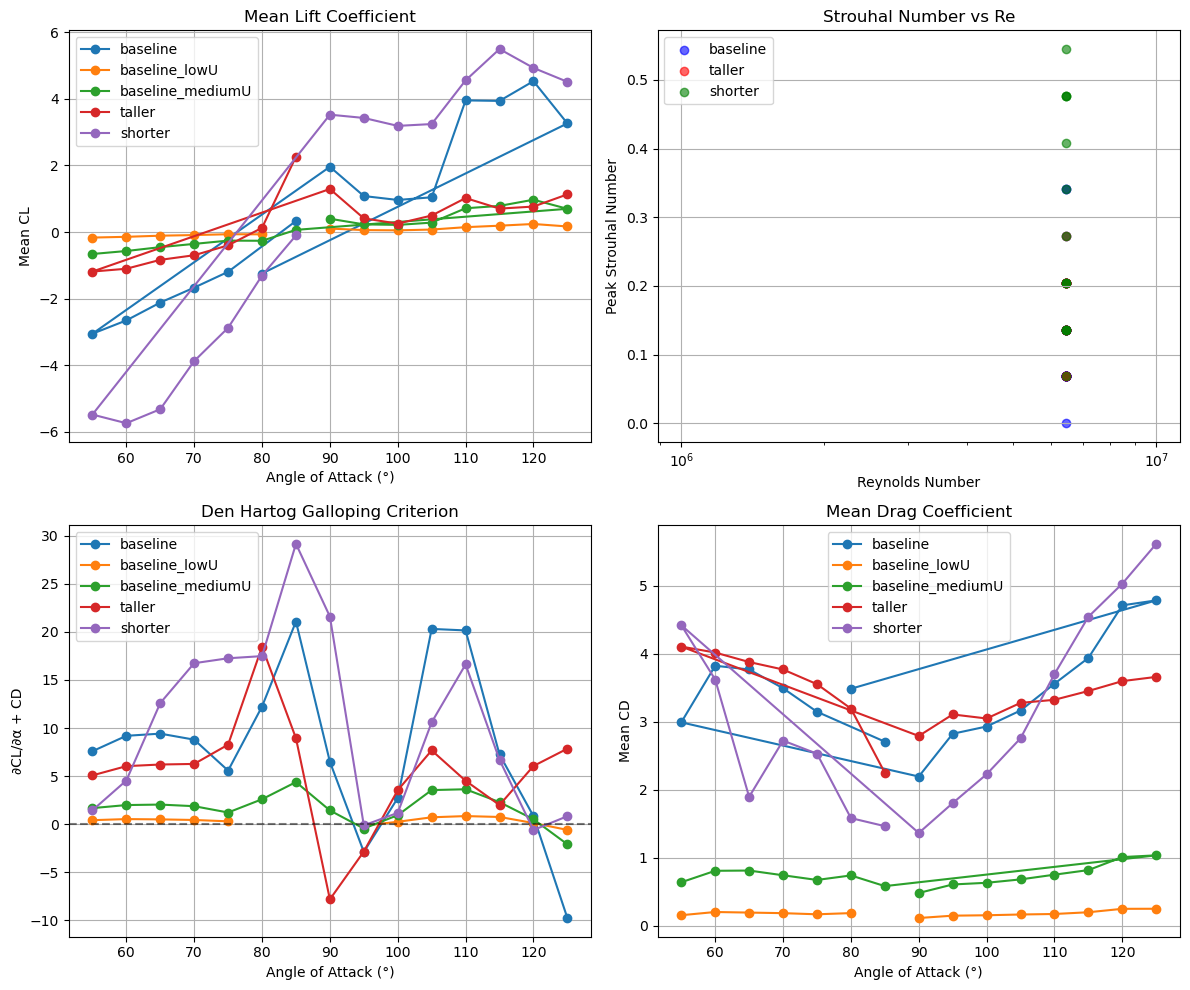

In [10]:
# Process all data
summary_df = preprocess_all_data(
    base_path="D:/Projects/aeroelasticity/data",
    output_path="D:/Projects/aeroelasticity/processed_data"
)


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Mean CL vs angle for different configurations
ax = axes[0, 0]
for shape_variant in summary_df['shape_variant'].unique():
    data = summary_df[summary_df['shape_variant'] == shape_variant]
    ax.plot(data['angle'], data['mean_cl'], 'o-', label=shape_variant)
ax.set_xlabel('Angle of Attack (°)')
ax.set_ylabel('Mean CL')
ax.set_title('Mean Lift Coefficient')
ax.legend()
ax.grid(True)

# Plot 2: Strouhal number vs Reynolds number
ax = axes[0, 1]
colors = {'baseline': 'blue', 'taller': 'red', 'shorter': 'green'}
for shape in summary_df['shape'].unique():
    data = summary_df[summary_df['shape'] == shape]
    ax.scatter(data['Re'], data['st_peak'], c=colors[shape], label=shape, alpha=0.6)
ax.set_xlabel('Reynolds Number')
ax.set_ylabel('Peak Strouhal Number')
ax.set_title('Strouhal Number vs Re')
ax.set_xscale('log')
ax.legend()
ax.grid(True)

# Plot 3: Den Hartog criterion check
ax = axes[1, 0]
for shape_variant in summary_df['shape_variant'].unique():
    data = summary_df[summary_df['shape_variant'] == shape_variant].sort_values('angle')
    # Approximate derivative using finite differences
    dCl_dalpha = np.gradient(data['mean_cl'].values, np.radians(data['angle'].values))
    den_hartog = dCl_dalpha + data['mean_cd'].values
    ax.plot(data['angle'], den_hartog, 'o-', label=shape_variant)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Angle of Attack (°)')
ax.set_ylabel('∂CL/∂α + CD')
ax.set_title('Den Hartog Galloping Criterion')
ax.legend()
ax.grid(True)

# Plot 4: Mean CD vs angle
ax = axes[1, 1]
for shape_variant in summary_df['shape_variant'].unique():
    data = summary_df[summary_df['shape_variant'] == shape_variant]
    ax.plot(data['angle'], data['mean_cd'], 'o-', label=shape_variant)
ax.set_xlabel('Angle of Attack (°)')
ax.set_ylabel('Mean CD')
ax.set_title('Mean Drag Coefficient')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.savefig("processed_data/preprocessing_summary.png", dpi=150)
plt.show()